<a href="https://colab.research.google.com/github/znah/notebooks/blob/master/tutorials/implicit_sdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Toy implementation of the [Implicit Geometric Regularization for Learning Shapes](https://arxiv.org/abs/2002.10099) paper



In [1]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

131


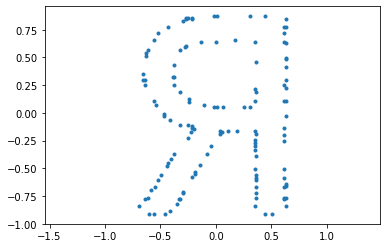

In [3]:
import PIL.ImageFont, PIL.ImageDraw

def gen_image(s, font_size=200, pad=5):
  font = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)
  w, h = font.getsize(s)
  im = PIL.Image.new('L', (w+pad*2, h+pad*2))
  draw  = PIL.ImageDraw.Draw(im)
  draw.text((pad, pad), s, font=font, stroke_width=1, stroke_fill=255)
  im = np.float32(im)/255.0
  return im

y, x = gen_image('Я').nonzero()
points = np.stack([x, -y], -1).astype(np.float32)
points -= points.mean(0)
points /= points.std()*2.0
points = points[np.random.rand(len(points))>0.9]
print(len(points))

x, y = points.T
pl.plot(x, y, '.')
pl.axis('equal');
points = tf.convert_to_tensor(points)

In [4]:
def vis_f(sdf):
  y, x = np.mgrid[-1.5:1.5:256j, -1.5:1.5:256j]
  coords = np.stack([x, y], -1).astype(np.float32)
  dist = sdf(coords)[...,0]
  f = pl.figure(figsize=(10, 8))
  pl.axis('equal')
  pl.contourf(x, y, dist, 16);
  pl.colorbar();
  pl.contour(x, y, dist, levels=[0.0], colors='white');

  dist, point_grad = val_and_grad(sdf, points)
  x, y = points.numpy().T
  u, v = point_grad.numpy().T
  pl.quiver(x, y, u, v, color='white')

  f.canvas.draw()
  w, h = f.canvas.get_width_height()
  rgba = np.frombuffer(f.canvas.buffer_rgba(), np.uint8).reshape(h, w, 4)
  rgb, a = rgba[...,:3], rgba[...,3:]/255.0
  img = np.uint8(rgb*a + 255*(1.0-a))

  pl.show()
  return img

def val_and_grad(sdf, points):
  with tf.GradientTape() as g:
    g.watch(points)
    dist = sdf(points)
  point_grad = g.gradient(dist, points)
  return dist, point_grad

def loss_f(sdf):
  n = len(points)
  all_points = tf.concat([points, tf.random.uniform([500, 2], -2.0, 2.0)], 0)
  dist, grad = val_and_grad(sdf, all_points)
  surface_loss = tf.reduce_mean(tf.square(dist[:n]))
  grad_norm2 = tf.reduce_sum(tf.square(grad), -1)
  grad_loss = tf.reduce_mean(tf.square(grad_norm2-1.0))
  return surface_loss*100.0 + grad_loss

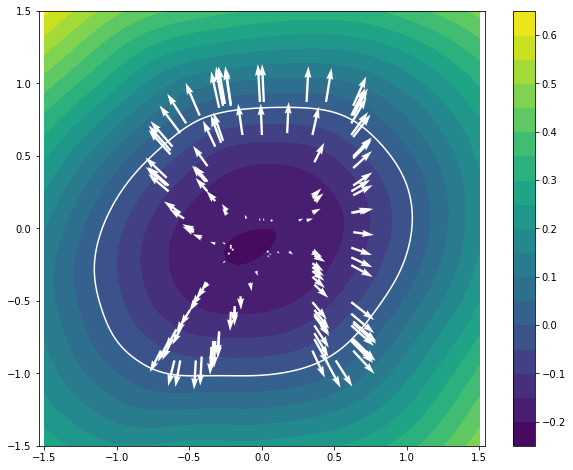

In [5]:
#@title init {vertical-output: true}
ch = 80
f = tf.nn.swish
sdf = Sequential([
  Dense(ch, f, kernel_initializer=tf.initializers.random_normal(0.0, 3.0)),
  Dense(ch, f),
  Dense(ch, f),
  Dense(1, kernel_initializer=tf.initializers.random_normal(0.01, 0.001),
      bias_initializer=tf.initializers.constant(-0.2))
])

loss_log = []
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 6000], [3e-3, 1e-3, 3e-4])
trainer = tf.optimizers.Adam(lr)

@tf.function
def train_step():
  with tf.GradientTape() as g:
    loss = loss_f(sdf)
  params = g.watched_variables()
  grads = g.gradient(loss, params)
  trainer.apply_gradients(zip(grads, params))
  return loss

vis_f(sdf);

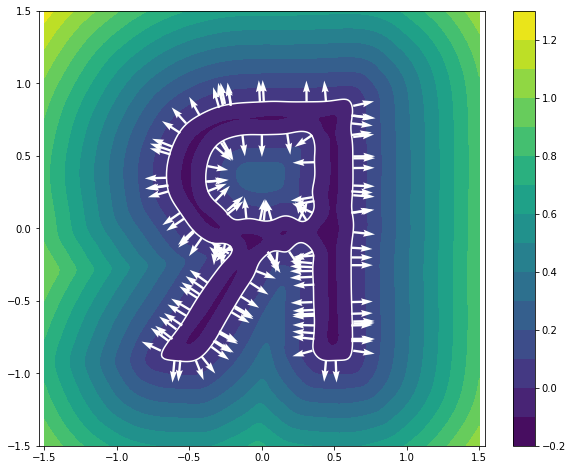

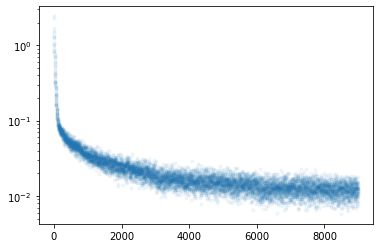

9001 0.013419975


In [6]:
#@title train {vertical-output: true}
with VideoWriter(fps=10) as vid:
  for i in range(10000):
    loss = train_step()
    loss_log.append(loss.numpy())
    if (i<100 and i%10==0) or (i<1000 and i%100==0) or i%1000==0:
      clear_output(True)
      vid.add(vis_f(sdf))
      pl.yscale('log')
      pl.plot(loss_log, '.', alpha=0.05);
      pl.show()
      print(len(loss_log), loss.numpy())
